# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with smaller network.  
Train on copious simulated data.  
Use uniform but longer RNA lengths: 1500   
Run on Alien.
79% accuracy.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 14:16:09 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 14:16:09.755969: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  # added -304 previously
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 14:16:10 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1500.0
Average ORF length: 1010.6000727272727
NC seqs
Average RNA length: 1500.0
Average ORF length: 208.47725454545454
2021-08-16 14:16:42 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1]
2021-08-16 14:16:43 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

{'A': 0.238, 'C': 0.262, 'G': 0.25533333333333336, 'T': 0.24466666666666667, 'AA': 0.0513675783855904, 'AC': 0.08205470313542361, 'AG': 0.052701801200800535, 'AT': 0.05203468979319546, 'CA': 0.07271514342895263, 'CC': 0.06537691794529686, 'CG': 0.06404269513008673, 'CT': 0.059372915276851235, 'GA': 0.056037358238825885, 'GC': 0.06004002668445631, 'GG': 0.0713809206137425, 'GT': 0.06804536357571714, 'TA': 0.058038692461641096, 'TC': 0.054036024016010674, 'TG': 0.06737825216811208, 'TT': 0.06537691794529686, 'AAA': 0.009345794392523364, 'AAC': 0.016688918558077435, 'AAG': 0.012016021361815754, 'AAT': 0.01335113484646195, 'ACA': 0.03204272363150868, 'ACC': 0.016688918558077435, 'ACG': 0.020026702269692925, 'ACT': 0.01335113484646195, 'AGA': 0.012683578104138851, 'AGC': 0.009345794392523364, 'AGG': 0.015353805073431242, 'AGT': 0.015353805073431242, 'ATA': 0.011348464619492658, 'ATC': 0.01335113484646195, 'ATG': 0.011348464619492658, 'ATT': 0.01602136181575434, 'CAA': 0.016688918558077435, 

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-16 14:17:13 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2720      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 14:17:13.938817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 14:17:13.978187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 14:17:13.979120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 14:17:13.979190: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 14:17:13.985499: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 14:17:13.985561: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 14:17:14 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-16 14:17:14.529281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 14:17:14.545829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-16 14:17:20.868188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 154/2084 [=>............................] - ETA: 1s - loss: 0.7225 - accuracy: 0.5007 

2021-08-16 14:17:21.184785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 9s 1ms/step - loss: 0.7053 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5005


2021-08-16 14:17:24.120021: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6938 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 3/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5012 - val_loss: 0.6928 - val_accuracy: 0.5005
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6923 - accuracy: 0.5164 - val_loss: 0.6786 - val_accuracy: 0.5996
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6823 - accuracy: 0.5602 - val_loss: 0.6500 - val_accuracy: 0.7181
INFO:tensorflow:

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4969 - accuracy: 0.7581 - val_loss: 0.4596 - val_accuracy: 0.7878
Epoch 92/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5011 - accuracy: 0.7576 - val_loss: 0.4573 - val_accuracy: 0.7879
Epoch 93/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5006 - accuracy: 0.7543 - val_loss: 0.4565 - val_accuracy: 0.7881
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 94/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4995 - accuracy: 0.7563 - val_loss: 0.4557 - val_accuracy: 0.7883
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 95/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4960 - accuracy: 0.7597 - val_loss: 0.4543 - val_accuracy: 0.7883
Epoch 96/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4975 - accuracy: 0.7589 - val_loss: 0.4557 - val_accuracy: 0.7885
INFO:tensorflow:Assets 

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4797 - accuracy: 0.7690 - val_loss: 0.4489 - val_accuracy: 0.7911
Epoch 195/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4743 - accuracy: 0.7738 - val_loss: 0.4498 - val_accuracy: 0.7907
Epoch 196/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4763 - accuracy: 0.7739 - val_loss: 0.4496 - val_accuracy: 0.7909
Epoch 197/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4771 - accuracy: 0.7735 - val_loss: 0.4514 - val_accuracy: 0.7910
Epoch 198/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4803 - accuracy: 0.7687 - val_loss: 0.4488 - val_accuracy: 0.7909
Epoch 199/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4782 - accuracy: 0.7709 - val_loss: 0.4492 - val_accuracy: 0.7907
Epoch 200/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4784 - accuracy: 0.7707 - val_loss: 0.4496 - val_ac

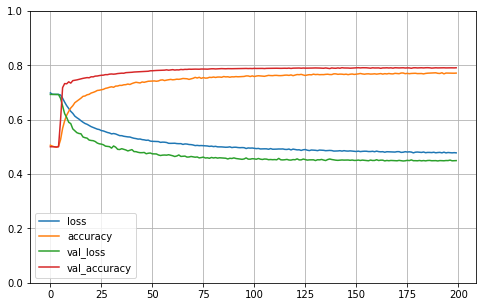

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7068 - accuracy: 0.5027 - val_loss: 0.6934 - val_accuracy: 0.4988
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6940 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6931 - val_accuracy: 0.4988
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6930 - val_accuracy: 0.5012
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6927 - accuracy: 0.5141 - val_loss: 0.6850 - val_accuracy: 0.5345
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6862 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5154 - accuracy: 0.7437 - val_loss: 0.4728 - val_accuracy: 0.7771
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5130 - accuracy: 0.7447 - val_loss: 0.4767 - val_accuracy: 0.7781
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5100 - accuracy: 0.7519 - val_loss: 0.4721 - val_accuracy: 0.7786
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5160 - accuracy: 0.7466 - val_loss: 0.4707 - val_accuracy: 0.7787
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5096 - accuracy: 0.7521 - val_loss: 0.4713 - val_accuracy: 0.7790
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5110 - accuracy: 0.7451 - val_loss: 0.4704 - val_accuracy: 0.7793
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5068 - accuracy: 0.7529 - val_loss: 0.4729 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4915 - accuracy: 0.7642 - val_loss: 0.4616 - val_accuracy: 0.7845
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4887 - accuracy: 0.7649 - val_loss: 0.4580 - val_accuracy: 0.7848
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4897 - accuracy: 0.7658 - val_loss: 0.4587 - val_accuracy: 0.7842
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4910 - accuracy: 0.7623 - val_loss: 0.4575 - val_accuracy: 0.7850
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4905 - accuracy: 0.7636 - val_loss: 0.4589 - val_accuracy: 0.7847
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4881 - accuracy: 0.7655 - val_loss: 0.4578 - val_accuracy: 0.7850
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4853 - accuracy: 0.7656 - val_loss: 0.4582 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4792 - accuracy: 0.7714 - val_loss: 0.4542 - val_accuracy: 0.7864
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4796 - accuracy: 0.7720 - val_loss: 0.4549 - val_accuracy: 0.7861
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4765 - accuracy: 0.7719 - val_loss: 0.4550 - val_accuracy: 0.7863
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4791 - accuracy: 0.7710 - val_loss: 0.4582 - val_accuracy: 0.7835
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4774 - accuracy: 0.7729 - val_loss: 0.4553 - val_accuracy: 0.7855
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4744 - accuracy: 0.7754 - val_loss: 0.4544 - val_accuracy: 0.7863
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4807 - accuracy: 0.7723 - val_loss: 0

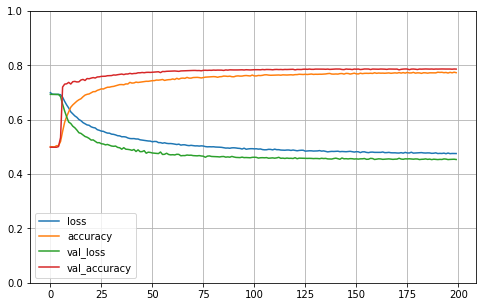

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7069 - accuracy: 0.5006 - val_loss: 0.6938 - val_accuracy: 0.4990
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6936 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6934 - val_accuracy: 0.4990
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5122 - accuracy: 0.7464 - val_loss: 0.4763 - val_accuracy: 0.7754
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5117 - accuracy: 0.7499 - val_loss: 0.4759 - val_accuracy: 0.7762
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5150 - accuracy: 0.7489 - val_loss: 0.4731 - val_accuracy: 0.7758
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5139 - accuracy: 0.7470 - val_loss: 0.4744 - val_accuracy: 0.7762
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5111 - accuracy: 0.7479 - val_loss: 0.4716 - val_accuracy: 0.7763
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5070 - accuracy: 0.7493 - val_loss: 0.4735 - val_accuracy: 0.7763
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5084 - accuracy: 0.7480 - val_loss: 0.4707 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4867 - accuracy: 0.7682 - val_loss: 0.4591 - val_accuracy: 0.7833
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4870 - accuracy: 0.7647 - val_loss: 0.4573 - val_accuracy: 0.7836
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4887 - accuracy: 0.7653 - val_loss: 0.4579 - val_accuracy: 0.7832
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4925 - accuracy: 0.7624 - val_loss: 0.4593 - val_accuracy: 0.7830
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4888 - accuracy: 0.7636 - val_loss: 0.4567 - val_accuracy: 0.7830
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4912 - accuracy: 0.7631 - val_loss: 0.4583 - val_accuracy: 0.7832
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4873 - accuracy: 0.7616 - val_loss: 0.4585 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4784 - accuracy: 0.7725 - val_loss: 0.4545 - val_accuracy: 0.7852
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4809 - accuracy: 0.7704 - val_loss: 0.4553 - val_accuracy: 0.7849
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4809 - accuracy: 0.7688 - val_loss: 0.4546 - val_accuracy: 0.7849
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4804 - accuracy: 0.7695 - val_loss: 0.4549 - val_accuracy: 0.7847
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4782 - accuracy: 0.7728 - val_loss: 0.4549 - val_accuracy: 0.7848
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4788 - accuracy: 0.7718 - val_loss: 0.4546 - val_accuracy: 0.7848
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4766 - accuracy: 0.7735 - val_loss: 0

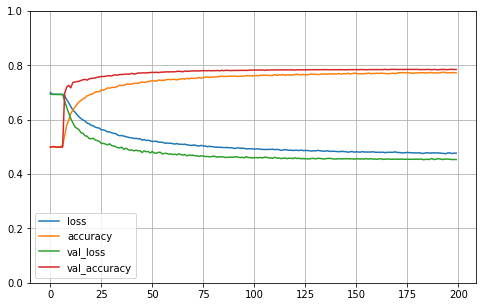

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [13]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-16 14:43:13 EDT


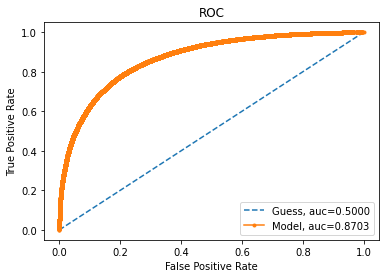

AUC: 87.03%
accuracy: 78.80%
2021-08-16 14:43:15 EDT


In [14]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-16 14:43:15 EDT


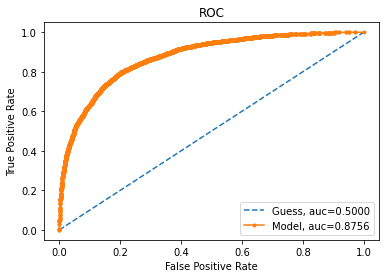

AUC: 87.56%
accuracy: 79.65%
2021-08-16 14:43:15 EDT


In [15]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)   # Doh! last_model should be best_model
show_time()